
MODEL           | a_Mach     | RMSE (dex) | R² Score   | Mean Y*   
--------------------------------------------------------------------------------
WILL (3π)       | 6.75e-11 | 0.1337     | 0.9442     | 0.59
Geom (2π)       | 1.01e-10 | 0.1405     | 0.9384     | 0.46
Geom (1π)       | 2.03e-10 | 0.1691     | 0.9107     | 0.29
Geom (4π)       | 5.06e-11 | 0.1330     | 0.9449     | 0.69
Geom (6π)       | 3.38e-11 | 0.1361     | 0.9424     | 0.85



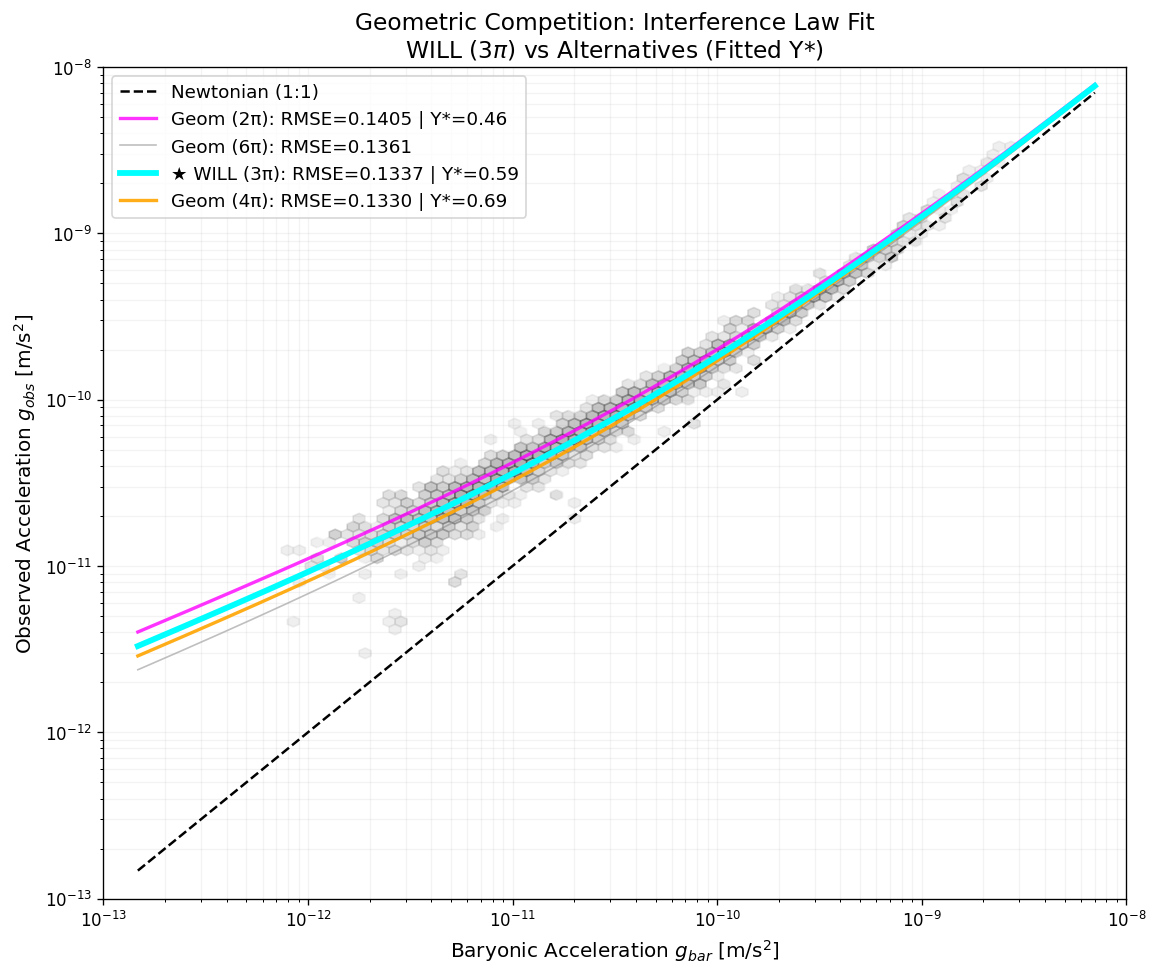

In [5]:
# ==============================================================================
# WILL RAR STRESS TEST: Competition with FITTED Y* (Interference Law)
# FULL VERSION - READY TO RUN
# Methodology: Allow Y* to vary per galaxy to separate Astrophysics from Gravity.
# Visualization: Plots ALL competitors to show the tight race.
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io
from scipy.optimize import minimize_scalar
from sklearn.metrics import r2_score, mean_squared_error

# -----------------------------
# CONSTANTS & SETTINGS
# -----------------------------
H0 = 65.5               # km/s/Mpc (WILL Prediction)
C_KMS = 299792.458
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Calculate Base Acceleration Term
H0_SI = (H0 * 1000) / MPC_TO_M
A_MACH_BASE = (C_KMS * 1000 * H0_SI)

MIN_G = 1e-13
APPLY_QUALITY_CUTS = True

# Data Sources
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# -----------------------------
# DATA LOADING
# -----------------------------
def load_data():
    print("Downloading SPARC data...")
    r1 = requests.get(URL_T1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(URL_T2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

# -----------------------------
# PHYSICS ENGINE (INTERFERENCE LAW)
# -----------------------------
def get_g_pred(g_bar, a_mach):
    # Interference Law: g_obs = g_bar + sqrt(g_bar * a_Mach)
    # This corresponds to V_tot^2 = V_bar^2 + sqrt(V_bar^2 * a * r)
    return g_bar + np.sqrt(g_bar * a_mach)

def fit_galaxy_y(galaxy_data, a_mach):
    # Prepare vectors
    v_gas = galaxy_data["Vgas"].values
    v_disk = galaxy_data["Vdisk"].values
    v_bul = galaxy_data["Vbul"].values
    rad = galaxy_data["Rad"].values
    v_obs = galaxy_data["Vobs"].values

    # Pre-calculate components to speed up fitting
    v_gas_sq = np.abs(v_gas)*v_gas
    v_disk_sq = np.abs(v_disk)*v_disk
    v_bul_sq = np.abs(v_bul)*v_bul

    # Conversion factor to m/s^2
    conv = (1000.0**2) / KPC_TO_M
    g_obs = ((v_obs**2) / rad) * conv

    def objective(y_val):
        # Baryonic acceleration with this Y*
        v_bar_sq = v_gas_sq + y_val * (v_disk_sq + v_bul_sq)
        v_bar_sq = np.maximum(v_bar_sq, 1e-5) # Prevent negative
        g_bar = (v_bar_sq / rad) * conv

        # Physics Prediction
        g_pred = get_g_pred(g_bar, a_mach)

        # Error (Log space to handle dynamic range)
        res = np.log10(g_pred) - np.log10(g_obs)
        return np.sum(res**2)

    # Fit Y* within physical bounds (0.05 to 5.0)
    res = minimize_scalar(objective, bounds=(0.05, 5.0), method='bounded')
    best_y = res.x

    # Return best vectors
    v_bar_sq = v_gas_sq + best_y * (v_disk_sq + v_bul_sq)
    v_bar_sq = np.maximum(v_bar_sq, 1e-5)
    g_bar_best = (v_bar_sq / rad) * conv

    return g_bar_best, g_obs, best_y

# -----------------------------
# EVALUATION LOOP
# -----------------------------
def run_stress_test(t1, t2):
    models = [
        {"label": "WILL (3π)", "denom": 3 * np.pi, "color": "cyan", "style": "-"},
        {"label": "Geom (2π)", "denom": 2 * np.pi, "color": "magenta", "style": "--"},
        {"label": "Geom (1π)", "denom": 1 * np.pi, "color": "red", "style": ":"},
        {"label": "Geom (4π)", "denom": 4 * np.pi, "color": "orange", "style": "--"},
        {"label": "Geom (6π)", "denom": 6 * np.pi, "color": "yellow", "style": ":"}
    ]

    print("\n" + "="*80)
    print(f"{'MODEL':<15} | {'a_Mach':<10} | {'RMSE (dex)':<10} | {'R² Score':<10} | {'Mean Y*':<10}")
    print("-" * 80)

    final_results = []

    for m in models:
        a_mach = A_MACH_BASE / m["denom"]
        m["val"] = a_mach

        all_g_bar = []
        all_g_obs = []
        y_stars = []

        for gal in t1["Name"].unique():
            props = t1[t1["Name"] == gal]
            if len(props) == 0: continue
            if APPLY_QUALITY_CUTS and (props.iloc[0]["Inc"] < 30 or props.iloc[0]["Qual"] > 2): continue

            data = t2[t2["Name"] == gal]
            if len(data) < 3: continue

            # FIT Y* FOR THIS GALAXY & THIS MODEL
            gb, go, best_y = fit_galaxy_y(data, a_mach)

            # Quality cut on acceleration
            mask = (gb > MIN_G) & (go > MIN_G)
            all_g_bar.extend(gb[mask])
            all_g_obs.extend(go[mask])
            y_stars.append(best_y)

        # Calc Stats
        g_bar_arr = np.array(all_g_bar)
        g_obs_arr = np.array(all_g_obs)

        g_pred = get_g_pred(g_bar_arr, a_mach)

        lg_obs = np.log10(g_obs_arr)
        lg_pred = np.log10(g_pred)

        rmse = np.sqrt(mean_squared_error(lg_obs, lg_pred))
        r2 = r2_score(lg_obs, lg_pred)
        mean_y = np.mean(y_stars)

        m["rmse"] = rmse
        m["r2"] = r2
        m["mean_y"] = mean_y
        m["data_g_bar"] = g_bar_arr # Save for plot
        m["data_g_obs"] = g_obs_arr

        final_results.append(m)
        print(f"{m['label']:<15} | {a_mach:.2e} | {rmse:.4f}     | {r2:.4f}     | {mean_y:.2f}")

    print("="*80 + "\n")
    return final_results

# -----------------------------
# PLOTTING (ALL COMPETITORS)
# -----------------------------
def plot_rar_comparison(results):
    # Sort by RMSE to handle z-order (best on top)
    results.sort(key=lambda x: x["rmse"], reverse=True)

    plt.figure(figsize=(11, 9), dpi=120)

    # Extract data from the best model to use for the scatter plot
    # We use the 3pi data for the background points for consistency
    will_model = next((item for item in results if "3π" in item["label"]), results[0])
    g_bar = will_model["data_g_bar"]
    g_obs = will_model["data_g_obs"]

    # 1. Data Heatmap
    plt.hexbin(g_bar, g_obs, xscale='log', yscale='log', gridsize=80, cmap='gray_r', mincnt=1, bins='log', alpha=0.3)

    # 2. Newtonian Line
    line_x = np.logspace(np.log10(min(g_bar)), np.log10(max(g_bar)), 200)
    plt.plot(line_x, line_x, 'k--', linewidth=1.5, label='Newtonian (1:1)')

    # 3. Model Lines
    for m in results:
        # Skip the weakest models to keep plot clean (e.g. 1pi)
        if "1π" in m['label']: continue

        # Calculate curve
        # Interference Law: g_obs = g_bar + sqrt(g_bar * a)
        line_y = line_x + np.sqrt(line_x * m["val"])

        # Style logic
        if "3π" in m['label']:
            color = 'cyan'
            lw = 3.5
            zorder = 10
            alpha = 1.0
            label = f"★ {m['label']}: RMSE={m['rmse']:.4f} | Y*={m['mean_y']:.2f}"
        elif "4π" in m['label']:
            color = 'orange'
            lw = 2
            zorder = 9
            alpha = 0.9
            label = f"{m['label']}: RMSE={m['rmse']:.4f} | Y*={m['mean_y']:.2f}"
        elif "2π" in m['label']:
            color = 'magenta'
            lw = 2
            zorder = 8
            alpha = 0.8
            label = f"{m['label']}: RMSE={m['rmse']:.4f} | Y*={m['mean_y']:.2f}"
        else:
            color = 'gray'
            lw = 1
            zorder = 1
            alpha = 0.5
            label = f"{m['label']}: RMSE={m['rmse']:.4f}"

        plt.plot(line_x, line_y, color=color, linewidth=lw, linestyle='-', alpha=alpha, label=label, zorder=zorder)

    # Formatting
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'Baryonic Acceleration $g_{bar}$ [m/s$^2$]', fontsize=12)
    plt.ylabel(r'Observed Acceleration $g_{obs}$ [m/s$^2$]', fontsize=12)
    plt.title(f'Geometric Competition: Interference Law Fit\nWILL (3$\\pi$) vs Alternatives (Fitted Y*)', fontsize=14)
    plt.legend(fontsize=11, loc='upper left')
    plt.grid(True, which="both", ls="-", alpha=0.15)
    plt.xlim(1e-13, 1e-8)
    plt.ylim(1e-13, 1e-8)
    plt.show()

# -----------------------------
# MAIN EXECUTION
# -----------------------------
t1, t2 = load_data()
res = run_stress_test(t1, t2)
plot_rar_comparison(res)

Processing with a_Mach = 6.75e-11 (H0=65.5, Factor=3pi)...
Final Stats: RMSE = 0.1337 dex, Mean Y* = 0.5875


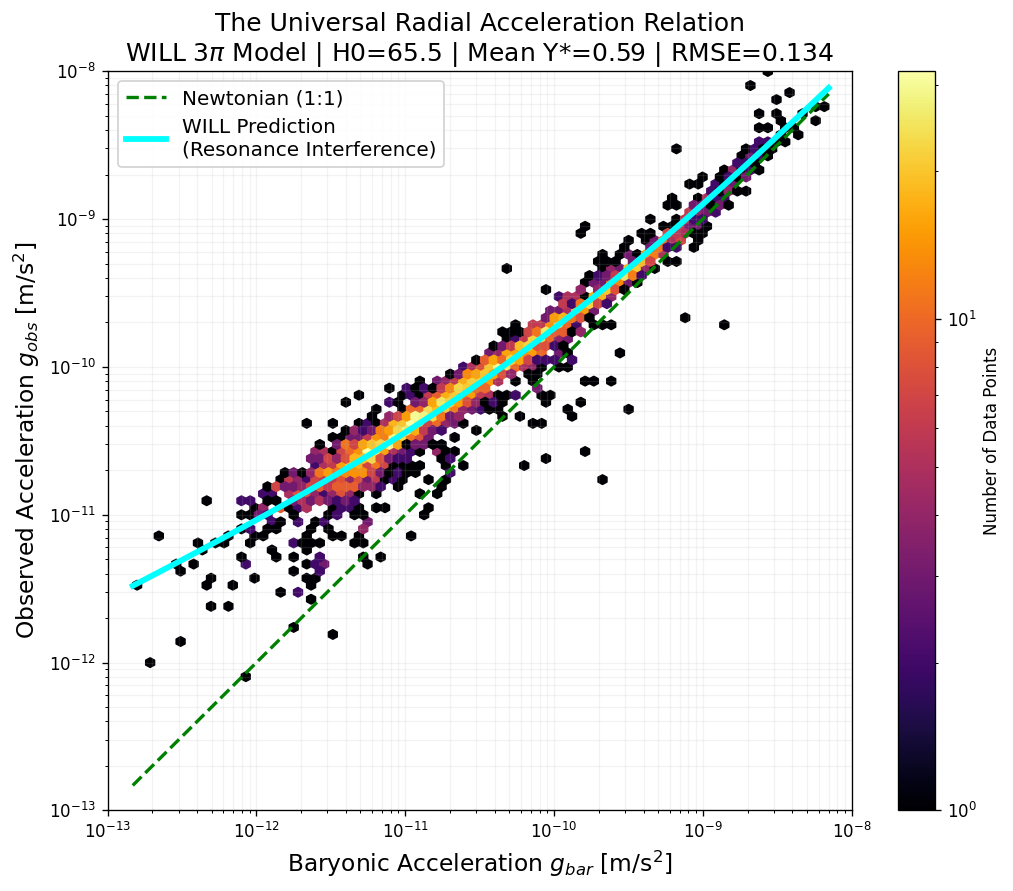

In [6]:
# ==============================================================================
# WILL RAR: THE MAIN SEQUENCE OF GALAXIES
# Generates the final high-quality plot for the paper using the Interference Law.
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests, io
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# SETTINGS (THE WINNING CONFIGURATION)
# -----------------------------
H0 = 65.5               # km/s/Mpc (WILL Prediction)
C_KMS = 299792.458
MPC_TO_M = 3.08567758e22
KPC_TO_M = 3.08567758e19

# Calculate a_Mach for WILL (3pi)
H0_SI = (H0 * 1000) / MPC_TO_M
A_MACH = (C_KMS * 1000 * H0_SI) / (3 * np.pi)

MIN_G = 1e-13
APPLY_QUALITY_CUTS = True

# Data Sources
URL_T1 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table1.dat"
URL_T2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# -----------------------------
# DATA LOADING
# -----------------------------
def load_data():
    print("Downloading SPARC data...")
    r1 = requests.get(URL_T1); r1.raise_for_status()
    t1 = pd.read_fwf(io.BytesIO(r1.content), colspecs=[(0,11), (30,34), (113,114)], header=None, names=["Name", "Inc", "Qual"])
    t1["Inc"] = pd.to_numeric(t1["Inc"], errors="coerce")
    t1["Qual"] = pd.to_numeric(t1["Qual"], errors="coerce")

    r2 = requests.get(URL_T2); r2.raise_for_status()
    t2 = pd.read_fwf(io.BytesIO(r2.content), colspecs=[(0,11), (19,25), (26,32), (33,38), (39,45), (46,52), (53,59)], header=None, names=["Name", "Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"])
    for c in ["Rad", "Vobs", "e_Vobs", "Vgas", "Vdisk", "Vbul"]: t2[c] = pd.to_numeric(t2[c], errors="coerce")
    t2 = t2.dropna(subset=["Name", "Rad", "Vobs"])
    t2 = t2[(t2["Rad"] > 0) & (t2["Vobs"] > 0)]
    return t1, t2

# -----------------------------
# PHYSICS ENGINE (INTERFERENCE LAW)
# -----------------------------
def get_g_pred(g_bar):
    # Interference Law: g_obs = g_bar + sqrt(g_bar * a_Mach)
    return g_bar + np.sqrt(g_bar * A_MACH)

def fit_galaxy_y(galaxy_data):
    # Prepare vectors
    v_gas = galaxy_data["Vgas"].values
    v_disk = galaxy_data["Vdisk"].values
    v_bul = galaxy_data["Vbul"].values
    rad = galaxy_data["Rad"].values
    v_obs = galaxy_data["Vobs"].values

    # Pre-calculate components
    v_gas_sq = np.abs(v_gas)*v_gas
    v_disk_sq = np.abs(v_disk)*v_disk
    v_bul_sq = np.abs(v_bul)*v_bul

    conv = (1000.0**2) / KPC_TO_M
    g_obs = ((v_obs**2) / rad) * conv

    def objective(y_val):
        # Baryonic acceleration
        v_bar_sq = v_gas_sq + y_val * (v_disk_sq + v_bul_sq)
        v_bar_sq = np.maximum(v_bar_sq, 1e-5)
        g_bar = (v_bar_sq / rad) * conv

        # Physics Prediction (WILL Interference)
        g_pred = get_g_pred(g_bar)

        # Residuals in log space
        res = np.log10(g_pred) - np.log10(g_obs)
        return np.sum(res**2)

    # Fit Y* (0.05 to 5.0)
    res = minimize_scalar(objective, bounds=(0.05, 5.0), method='bounded')
    best_y = res.x

    # Return best vectors for plotting
    v_bar_sq = v_gas_sq + best_y * (v_disk_sq + v_bul_sq)
    v_bar_sq = np.maximum(v_bar_sq, 1e-5)
    g_bar_best = (v_bar_sq / rad) * conv

    return g_bar_best, g_obs, best_y

# -----------------------------
# MAIN PROCESSING
# -----------------------------
def process_rar(t1, t2):
    print(f"Processing with a_Mach = {A_MACH:.2e} (H0={H0}, Factor=3pi)...")

    all_g_bar = []
    all_g_obs = []
    y_stars = []

    for gal in t1["Name"].unique():
        props = t1[t1["Name"] == gal]
        if len(props) == 0: continue
        if APPLY_QUALITY_CUTS and (props.iloc[0]["Inc"] < 30 or props.iloc[0]["Qual"] > 2): continue

        data = t2[t2["Name"] == gal]
        if len(data) < 3: continue

        # Fit Y* for this galaxy to clean up astrophysics
        gb, go, best_y = fit_galaxy_y(data)

        # Quality cut on low acceleration (remove noise floor)
        mask = (gb > MIN_G) & (go > MIN_G)
        all_g_bar.extend(gb[mask])
        all_g_obs.extend(go[mask])
        y_stars.append(best_y)

    return np.array(all_g_bar), np.array(all_g_obs), np.mean(y_stars)

# -----------------------------
# PLOTTING
# -----------------------------
def plot_main_sequence(g_bar, g_obs, mean_y):
    plt.figure(figsize=(10, 8), dpi=120)

    # 1. Hexbin Heatmap (The Data)
    # Using 'inferno' or 'magma' for high contrast
    hb = plt.hexbin(g_bar, g_obs, xscale='log', yscale='log', gridsize=80, cmap='inferno', mincnt=1, bins='log')
    cb = plt.colorbar(hb, label='Number of Data Points')

    # 2. Newtonian Line (No Dark Matter)
    line_x = np.logspace(np.log10(min(g_bar)), np.log10(max(g_bar)), 200)
    plt.plot(line_x, line_x, 'g--', linewidth=2, label='Newtonian (1:1)')

    # 3. WILL Prediction Line
    # g_obs = g_bar + sqrt(g_bar * a_mach)
    line_y = get_g_pred(line_x)

    # Plot Theoretical Curve
    plt.plot(line_x, line_y, color='cyan', linewidth=3.5, label=f'WILL Prediction\n(Resonance Interference)')

    # Calculate RMSE for legend
    lg_obs = np.log10(g_obs)
    lg_pred = np.log10(get_g_pred(g_bar))
    rmse = np.sqrt(mean_squared_error(lg_obs, lg_pred))

    # Formatting
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel(r'Baryonic Acceleration $g_{bar}$ [m/s$^2$]', fontsize=14)
    plt.ylabel(r'Observed Acceleration $g_{obs}$ [m/s$^2$]', fontsize=14)
    plt.title(f'The Universal Radial Acceleration Relation\nWILL 3$\\pi$ Model | H0={H0} | Mean Y*={mean_y:.2f} | RMSE={rmse:.3f}', fontsize=15)

    plt.legend(fontsize=12, loc='upper left', framealpha=0.9)
    plt.grid(True, which="both", ls="-", alpha=0.15)
    plt.xlim(1e-13, 1e-8)
    plt.ylim(1e-13, 1e-8)

    print(f"Final Stats: RMSE = {rmse:.4f} dex, Mean Y* = {mean_y:.4f}")
    plt.show()

# -----------------------------
# RUN
# -----------------------------
t1_dat, t2_dat = load_data()
g_b, g_o, mean_y_val = process_rar(t1_dat, t2_dat)
plot_main_sequence(g_b, g_o, mean_y_val)